# Introduction


In this notebook, we will try to train some categorical models namely, logistic regression, decision tree, random forest, xgboost and LightGBM. In order to train these models, we will covert the audio files into numerical values and will feed these numerical values into the above mentioned models to train them. According the the results we will see, we can conclude that this approach may not yield a good model for our purposes. 

# Importing Libraries

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 
import librosa
import librosa.display
from tqdm import tqdm

import tensorflow as tf
import tensorflow_io as tfio
import noisereduce as nr


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

# Functions

## Printing results of models

In [80]:
def print_results(model, X_train=X_train, y_train=y_train
                  ,X_test=X_test, y_test=y_test):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    
    ax1 = axes[0]
    plot_confusion_matrix(model, X_test, y_test, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax1)
    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[1]
    plot_confusion_matrix(model, X_train, y_train, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax2)
    
    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    ### Presenting Classification Report as a DataFrame
    
    train_class = classification_report(y_train, model.predict(X_train), output_dict = True)
    test_class  = classification_report(y_test, model.predict(X_test), output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"6": f"{list(le.inverse_transform([1]))[0]}",
                             "5": f"{list(le.inverse_transform([1]))[0]}",
                             "4": f"{list(le.inverse_transform([1]))[0]}",
                             "3": f"{list(le.inverse_transform([1]))[0]}",
                             "2": f"{list(le.inverse_transform([1]))[0]}",
                             "1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    
    for item in list(report.columns):
        report[item] = report[item].apply(lambda x: np.round(x,2))
        
    
    return report

## Converting audio files to numerical values

In [39]:
def get_wave(filename):
    file_contents = tf.io.read_file(filename)  
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = nr.reduce_noise(y=x, sr=sample_rate)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## Creating equal size arrays for training

In [43]:
def zero_padding(filename, n_slice = 60000):
    
    waveform = get_wave(filename)
    waveform = waveform[:n_slice]
    zero_padding = tf.zeros([n_slice] - tf.shape(waveform),
      dtype =tf.float32)
    
    waveform = tf.cast(waveform, dtype = tf.float32)
    equal_length = tf.concat([waveform, zero_padding], axis = 0)
    
    return equal_length

# Importing Data

In this section, we will import the train and test sets and in the next section we will create numerical values to train the models.

In [4]:
train = pd.read_csv("../Train-Test-Split/train.csv")
test = pd.read_csv("../Train-Test-Split/test.csv")

train.drop("Unnamed: 0", axis = 1, inplace = True)
test.drop("Unnamed: 0", axis = 1, inplace = True)

In [7]:
train.head()

,path,name,target
0,/Users/miladshirani/Documents/Flatiron/phase_5...,YAF_walk_angry.wav,angry
1,/Users/miladshirani/Documents/Flatiron/phase_5...,OAF_sail_ps.wav,surprise
2,/Users/miladshirani/Documents/Flatiron/phase_5...,OAF_pick_neutral.wav,neutral
3,/Users/miladshirani/Documents/Flatiron/phase_5...,OAF_rat_neutral.wav,neutral
4,/Users/miladshirani/Documents/Flatiron/phase_5...,OAF_came_angry.wav,angry


# Converting Audio to Vectors

In this section, we will convert the audio files to numerical arrays of equal size to train models with.

In [55]:
n_slice = 60000

X_train = pd.DataFrame(columns = list(range(0, n_slice)), 
                         index = train.index)
print("train_wave ZERO  DONE!")

for i in range(0,len(train)):
    path   = train["path"].iloc[i]
    values = zero_padding(path)
    X_train.iloc[i] = pd.DataFrame(values).transpose()
print("train is DONE")

train_wave ZERO  DONE!
train is DONE


In [56]:
n_slice = 60000

X_test = pd.DataFrame(columns = list(range(0, n_slice)), 
                         index = test.index)
print("train_wave ZERO  DONE!")

for i in range(0,len(test)):
    path   = train["path"].iloc[i]
    values = zero_padding(path)
    X_test.iloc[i] = pd.DataFrame(values).transpose()
print("train is DONE")

train_wave ZERO  DONE!
train is DONE


In [58]:
le = LabelEncoder()
y_train = le.fit_transform(train["target"])
y_test  = le.transform(test["target"])

# Modeling

In this section, we will train categorical models, namely logistic regression, decision tree, random forest, xgboos and lightgbm on the numerical arrays obtained by converting audio files. 

## Logistic Regression

In [64]:
lr = LogisticRegression(solver='liblinear',random_state=42)
lr.fit(X_train, y_train)
print("Fitting Done!")

Fitting Done!


angry  disgust  disgust  disgust  disgust  disgust  disgust  \
data  index                                                                     
TEST  precision    0.17     0.16     0.15     0.15     0.15     0.24     0.10   
      recall       0.19     0.14     0.16     0.15     0.18     0.21     0.09   
      f1-score     0.18     0.15     0.15     0.15     0.16     0.23     0.09   
      support     80.00    80.00    80.00    80.00    80.00    80.00    80.00   
TRAIN precision    1.00     0.99     1.00     1.00     0.99     0.99     1.00   
      recall       1.00     1.00     1.00     1.00     0.98     1.00     1.00   
      f1-score     1.00     0.99     1.00     1.00     0.99     1.00     1.00   
      support    320.00   320.00   320.00   320.00   320.00   320.00   320.00   

                 accuracy  macro avg  weighted avg  
data  index                                         
TEST  precision      0.16       0.16          0.16  
      recall         0.16       0.16          0.16  
      f1-score       0.16       0.16          0.16  
      support        0.16     560.00        560.00  
TRAIN precision      1.00       1.00          1.00  
      recall         1.00       1.00          1.00  
      f1-score       1.00       1.00          1.00  
      support        1.00    2240.00       2240.00

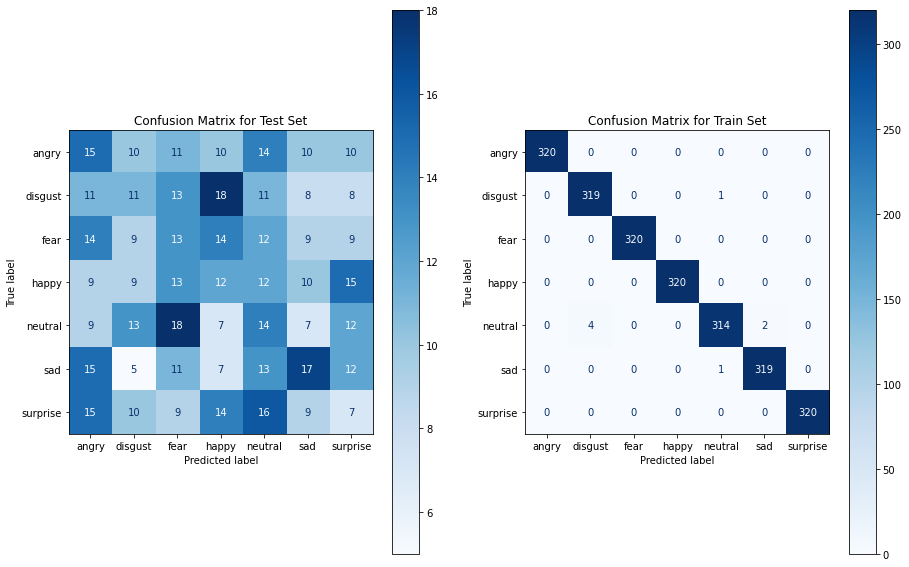

In [71]:
print_results(lr)

## Decision Tree

Fitting Tree


angry  disgust  disgust  disgust  disgust  disgust  disgust  \
data  index                                                                     
TEST  precision    0.17     0.16     0.15     0.15     0.15     0.24     0.10   
      recall       0.19     0.14     0.16     0.15     0.18     0.21     0.09   
      f1-score     0.18     0.15     0.15     0.15     0.16     0.23     0.09   
      support     80.00    80.00    80.00    80.00    80.00    80.00    80.00   
TRAIN precision    1.00     1.00     1.00     1.00     1.00     1.00     1.00   
      recall       1.00     1.00     1.00     1.00     1.00     1.00     1.00   
      f1-score     1.00     1.00     1.00     1.00     1.00     1.00     1.00   
      support    320.00   320.00   320.00   320.00   320.00   320.00   320.00   

                 accuracy  macro avg  weighted avg  
data  index                                         
TEST  precision      0.16       0.16          0.16  
      recall         0.16       0.16          0.16  
      f1-score       0.16       0.16          0.16  
      support        0.16     560.00        560.00  
TRAIN precision      1.00       1.00          1.00  
      recall         1.00       1.00          1.00  
      f1-score       1.00       1.00          1.00  
      support        1.00    2240.00       2240.00

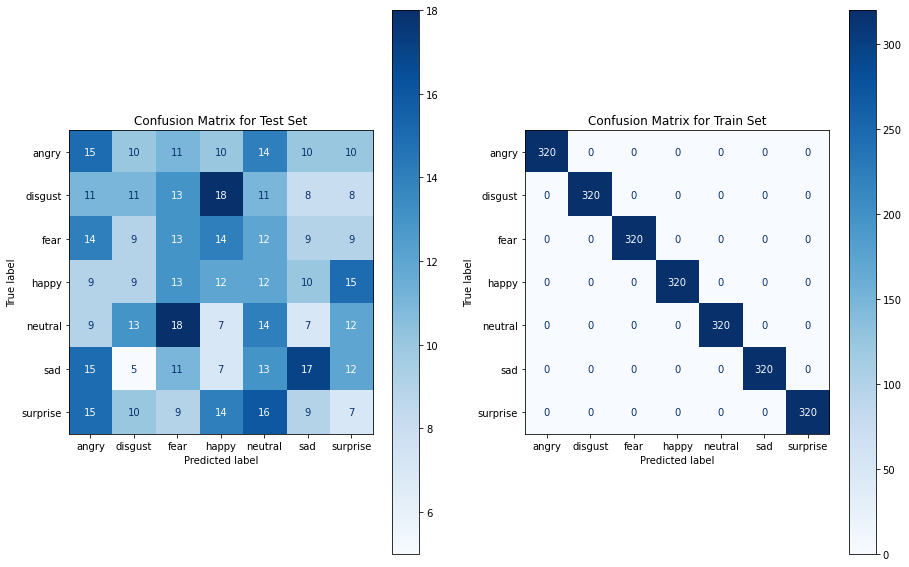

In [72]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

print("Fitting Tree")
print_results(tree)


## Random Forest

Fitting Tree


angry  disgust  disgust  disgust  disgust  disgust  disgust  \
data  index                                                                     
TEST  precision    0.19     0.13     0.17     0.18     0.20     0.26     0.00   
      recall       0.05     0.14     0.32     0.22     0.31     0.20     0.00   
      f1-score     0.08     0.13     0.22     0.20     0.24     0.23     0.00   
      support     80.00    80.00    80.00    80.00    80.00    80.00    80.00   
TRAIN precision    0.98     0.80     0.49     0.46     0.47     0.94     0.71   
      recall       0.20     0.95     0.92     0.52     0.68     0.85     0.16   
      f1-score     0.33     0.87     0.64     0.49     0.55     0.89     0.26   
      support    320.00   320.00   320.00   320.00   320.00   320.00   320.00   

                 accuracy  macro avg  weighted avg  
data  index                                         
TEST  precision      0.18       0.16          0.16  
      recall         0.18       0.18          0.18  
      f1-score       0.18       0.16          0.16  
      support        0.18     560.00        560.00  
TRAIN precision      0.61       0.69          0.69  
      recall         0.61       0.61          0.61  
      f1-score       0.61       0.58          0.58  
      support        0.61    2240.00       2240.00

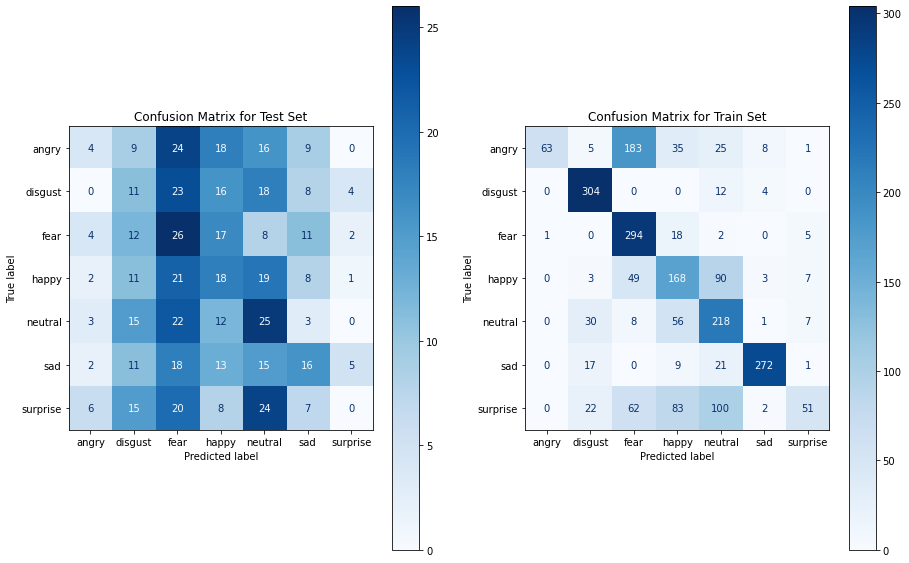

In [74]:
forest = RandomForestClassifier(criterion="entropy", 
                                n_estimators= 20,
                                max_depth = 5, 
                                bootstrap = True,
                                random_state = 42)

forest.fit(X_train, y_train)

print("Fitting Tree")
print_results(forest)

## XGBoost

In [81]:
xg = xgb.XGBClassifier(max_depth = 10, n_estimators= 15, seed=42,
                        alpha = 10, 
                        objective = 'multi:softmax', 
                        num_class = 7,
                        eval_metric = "auc")

xg.fit(X_train.values, y_train)

print("Fitting Done")


Fitting Done


angry  disgust  disgust  disgust  disgust  disgust  disgust  \
data  index                                                                     
TEST  precision    0.17     0.17     0.15     0.15     0.15     0.24     0.10   
      recall       0.19     0.14     0.16     0.15     0.18     0.21     0.09   
      f1-score     0.18     0.15     0.15     0.15     0.16     0.23     0.09   
      support     80.00    80.00    80.00    80.00    80.00    80.00    80.00   
TRAIN precision    1.00     1.00     0.99     1.00     0.99     1.00     1.00   
      recall       0.99     0.99     1.00     1.00     1.00     1.00     1.00   
      f1-score     1.00     1.00     1.00     1.00     1.00     1.00     1.00   
      support    320.00   320.00   320.00   320.00   320.00   320.00   320.00   

                 accuracy  macro avg  weighted avg  
data  index                                         
TEST  precision      0.16       0.16          0.16  
      recall         0.16       0.16          0.16  
      f1-score       0.16       0.16          0.16  
      support        0.16     560.00        560.00  
TRAIN precision      1.00       1.00          1.00  
      recall         1.00       1.00          1.00  
      f1-score       1.00       1.00          1.00  
      support        1.00    2240.00       2240.00

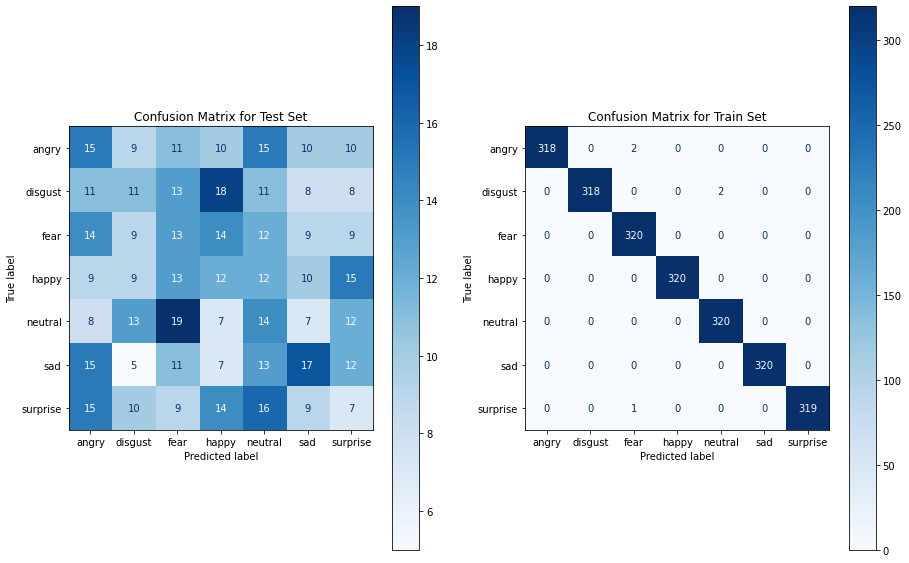

In [82]:
print_results(xg, X_train=X_train.values, y_train=y_train
                  ,X_test=X_test.values, y_test=y_test)

## LightGBM

In [84]:
params = {'num_boost_round':100,
        'learning_rate':0.02,
        'objective' : 'multiclass',
        'num_class' : 7,
        'depth':10,
        'eval_metric':'AUC',
        # 'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': 42
          }


# num_boost_round=100
light = lgb.LGBMClassifier(**params)
light.fit(X_train.values, y_train)

print("Fitting Done")

[LightGBM] [Warning] Unknown parameter: od_type
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: od_wait
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Fitting Done


angry  disgust  disgust  disgust  disgust  disgust  disgust  \
data  index                                                                     
TEST  precision    0.17     0.16     0.15     0.15     0.15     0.24     0.10   
      recall       0.19     0.14     0.16     0.15     0.18     0.21     0.09   
      f1-score     0.18     0.15     0.15     0.15     0.16     0.23     0.09   
      support     80.00    80.00    80.00    80.00    80.00    80.00    80.00   
TRAIN precision    1.00     1.00     1.00     1.00     1.00     1.00     1.00   
      recall       1.00     1.00     1.00     1.00     1.00     1.00     1.00   
      f1-score     1.00     1.00     1.00     1.00     1.00     1.00     1.00   
      support    320.00   320.00   320.00   320.00   320.00   320.00   320.00   

                 accuracy  macro avg  weighted avg  
data  index                                         
TEST  precision      0.16       0.16          0.16  
      recall         0.16       0.16          0.16  
      f1-score       0.16       0.16          0.16  
      support        0.16     560.00        560.00  
TRAIN precision      1.00       1.00          1.00  
      recall         1.00       1.00          1.00  
      f1-score       1.00       1.00          1.00  
      support        1.00    2240.00       2240.00

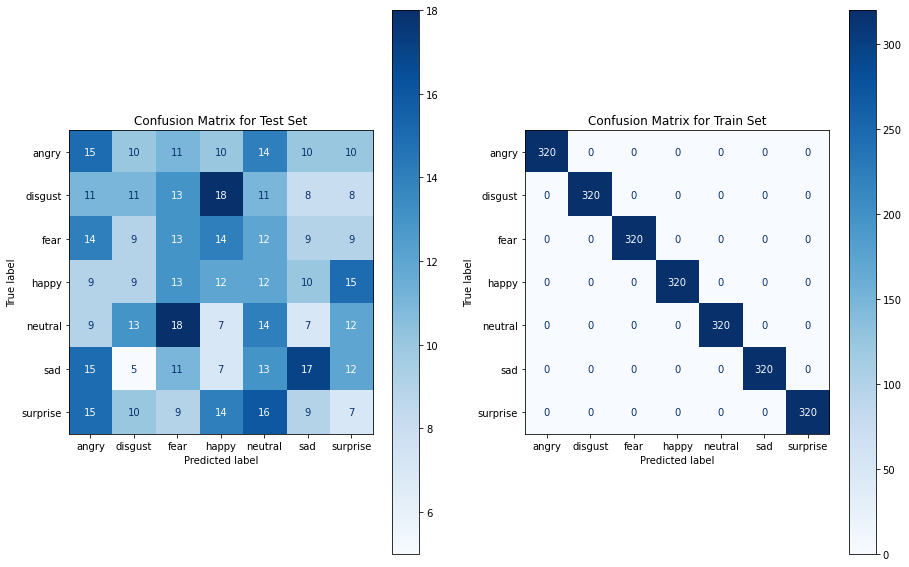

In [85]:
print_results(light , X_train = X_train.values, y_train = y_train,
                      X_test  = X_test.values , y_test  = y_test)

# Results and Conclusion

As we can see, these models did not perform well and we will need to try other way of modeling such as neural network. In the next notebook, we will present,design and train some neural networks on the mel spectrograms obtained in the EDA notebook.